In [18]:
import numpy as np
import pandas as pd
def generate_synthetic_data_v2(N, change_points_info, rv_params):
    """
    Generate a synthetic dataset with manually specified change points, supporting different distributions and parameters.
    
    Parameters:
    - N (int): Total length of the dataset.
    - change_points_info (dict): A dictionary specifying 'indices' (list of change point indices) and 'count' (number of change points).
    - rv_params (list): A nested list where each sub-list corresponds to a random variable (r.v.) and contains
                        dictionaries with keys 'dist' (distribution name) and distribution parameters for each segment.
    
    Returns:
    - np.ndarray: A 2D numpy array where each row corresponds to an r.v. and each column to a data point.
    """
    # Validate the change point information
    if change_points_info['count'] != len(change_points_info['indices']):
        raise ValueError("The count of change points does not match the number of indices provided.")
    
    # Initialize the dataset array
    data = np.zeros((len(rv_params), N))
    
    # Ensure the list of change point indices starts with 0 and ends with N for iteration
    cps = [0] + change_points_info['indices'] + [N]
    
    # Iterate over each segment defined by consecutive change points
    for i in range(len(cps) - 1):
        start, end = cps[i], cps[i+1]  # Start and end points of the current segment
        
        # Iterate over each random variable
        for rv_index, rv in enumerate(rv_params):
            # Get the parameters for the current r.v. and segment
            segment_params = rv[i]
            
            if segment_params['dist'] == 'normal':
                data[rv_index, start:end] = np.random.normal(segment_params['mu'], segment_params['sigma'], end - start)
            elif segment_params['dist'] == 'uniform':
                data[rv_index, start:end] = np.random.uniform(segment_params['low'], segment_params['high'], end - start)
            # Add more distribution cases as needed
            
    return data

N_5d = 1000  
change_points_5d = {
    'indices': [300, 600], 
    'count': 2  
}
rv_params_5d = [
    [  # First dimension
        {'dist': 'normal', 'mu': 0, 'sigma': 1},
        {'dist': 'uniform', 'low': 0, 'high': 5},
        {'dist': 'normal', 'mu': 5, 'sigma': 2},
    ],
    [  # Second dimension
        {'dist': 'uniform', 'low': -5, 'high': 0},
        {'dist': 'normal', 'mu': 2, 'sigma': 1},
        {'dist': 'uniform', 'low': 5, 'high': 10},
    ],
    [  # Third dimension
        {'dist': 'normal', 'mu': -2, 'sigma': 0.5},
        {'dist': 'normal', 'mu': 3, 'sigma': 1.5},
        {'dist': 'uniform', 'low': -3, 'high': 2},
    ],
    [  # Fourth dimension
        {'dist': 'uniform', 'low': 1, 'high': 4},
        {'dist': 'normal', 'mu': -1, 'sigma': 0.5},
        {'dist': 'normal', 'mu': 2, 'sigma': 1},
    ],
    [  # Fifth dimension
        {'dist': 'normal', 'mu': 1, 'sigma': 1},
        {'dist': 'uniform', 'low': 2, 'high': 6},
        {'dist': 'normal', 'mu': -3, 'sigma': 1.5},
    ],
]

synthetic_data_5d = generate_synthetic_data_v2(N_5d, change_points_5d, rv_params_5d)


In [19]:
import numpy as np
from joblib import Parallel, delayed
from densratio import densratio

class ChangePointDetectionRuLSIF:
    def __init__(self, alpha=0.1, sigma_range=[0.1], lambda_range=[0.1], kernel_num=100, metric="PE", 
                 periods=1, window_size=100, step=1, n_runs=1, debug=0):
        self.alpha = alpha
        self.sigma_range = sigma_range
        self.lambda_range = lambda_range
        self.kernel_num = kernel_num
        self.metric = metric
        self.periods = periods
        self.window_size = window_size
        self.step = step
        self.n_runs = n_runs
        self.debug = debug
        
        if self.sigma_range == 'auto':
            self.sigma_range = [10**i for i in range(-3, 6)]
        if self.lambda_range == 'auto':
            self.lambda_range = [10**i for i in range(-3, 6)]
            
    def densration_gridsearch(self, X_ref, X_test):
        score_max = -999.
        # Ensure sigma_range and lambda_range are lists
        sigma_list = [self.sigma_range] if isinstance(self.sigma_range, float) else self.sigma_range
        lambda_list = [self.lambda_range] if isinstance(self.lambda_range, float) else self.lambda_range

        for sigma in sigma_list:
            for lam in lambda_list:
                # Use lists for sigma and lambda parameters
                estimator_1 = densratio(X_ref, X_test, self.alpha, [sigma], [lam], self.kernel_num, verbose=False)
                estimator_2 = densratio(X_test, X_ref, self.alpha, [sigma], [lam], self.kernel_num, verbose=False)
                if self.metric == "PE":
                    score = estimator_1.alpha_PE + estimator_2.alpha_PE
                elif self.metric == "KL":
                    score = estimator_1.alpha_KL + estimator_2.alpha_KL
                else:
                    score = 0
                if score > score_max:
                    score_max = score
        return score_max

        
    def reference_test_predict(self, X_ref, X_test):
        score = self.densration_gridsearch(X_ref, X_test)
        return score
    
    def reference_test_predict_n_times(self, X_ref, X_test):
        scores = []
        for i in range(self.n_runs):
            ascore = self.reference_test_predict(X_ref, X_test)
            scores.append(ascore)
        return np.mean(scores)
        
    def predict(self, X):
        T, reference, test = [], [], []
        for i in range(self.window_size, len(X) - self.window_size, self.step):
            T.append(i)
            reference.append(X[i - self.window_size:i])
            test.append(X[i:i + self.window_size])
        scores = Parallel(n_jobs=-1)(delayed(self.reference_test_predict_n_times)(reference[i], test[i]) for i in range(len(reference)))
        return np.array(T), np.array(scores)


cpd_rulsif = ChangePointDetectionRuLSIF(window_size=100, step=10, n_runs=5)

# Detect change points
T_scores, scores = cpd_rulsif.predict(synthetic_data_5d.T)

In [20]:
from metrics import change_point_roc_auc
# Creating binary labels for evaluation
labels = np.zeros(N_5d)
# Marking a window around the true change points as change points for evaluation
window_size = 50  # Adjust based on your method's sensitivity
for cp in change_points_5d['indices']:
    labels[max(0, cp-window_size):min(N_5d, cp+window_size)] = 1

# Evaluating performance using ROC AUC
auc_score = change_point_roc_auc(np.arange(N_5d), labels, T_scores, scores, window_size)
print(f"ROC AUC Score: {auc_score}")

ROC AUC Score: 0.44125


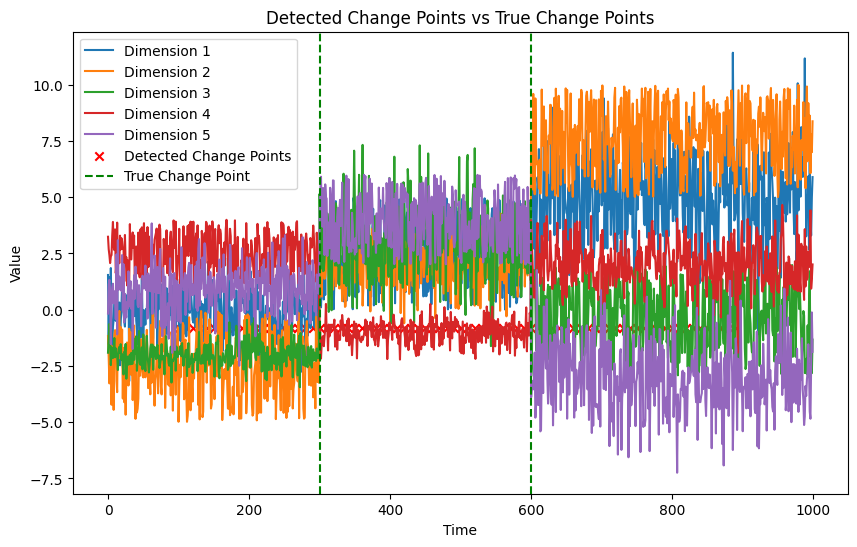

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for dim in range(len(rv_params_5d)):
    plt.plot(synthetic_data_5d[dim], label=f'Dimension {dim+1}')
plt.scatter(T_scores, scores, color='red', label='Detected Change Points', marker='x')
for cp in change_points_5d['indices']:
    plt.axvline(x=cp, color='green', linestyle='--', label='True Change Point' if cp == change_points_5d['indices'][0] else "")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Detected Change Points vs True Change Points')
plt.show()


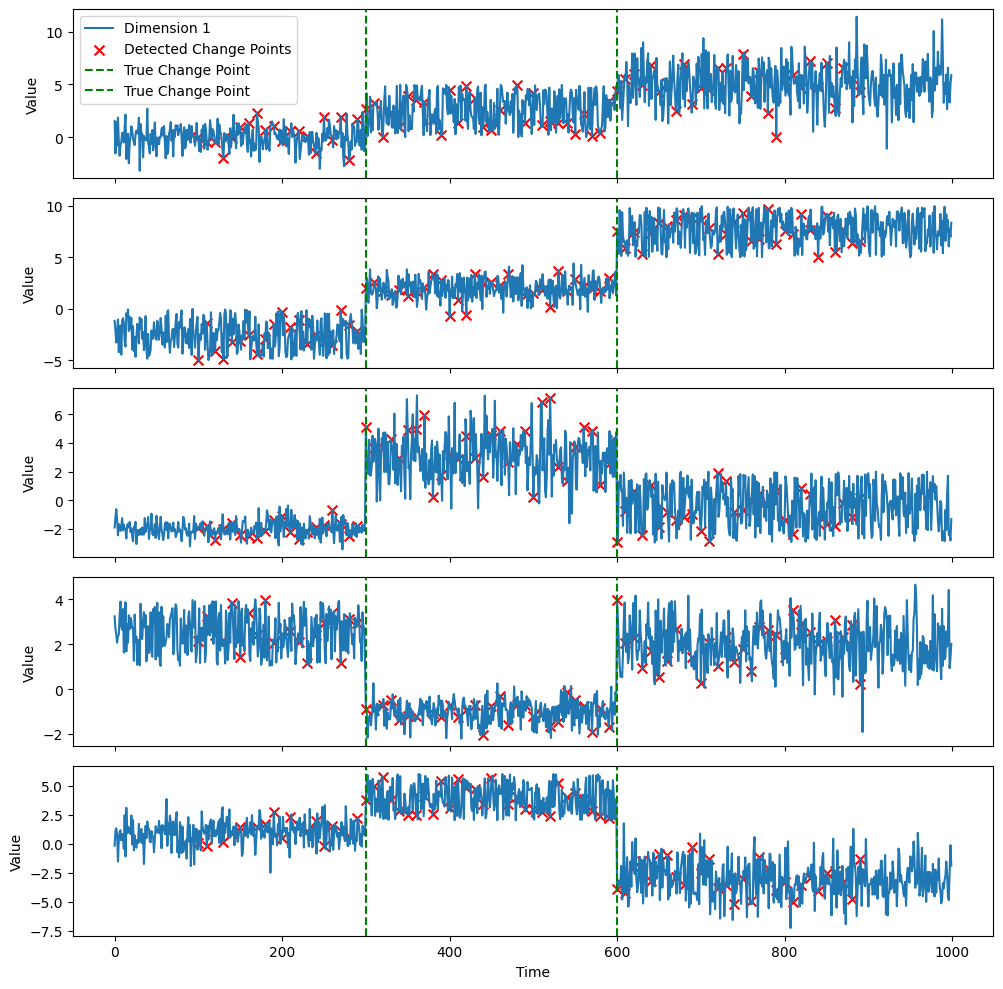

In [22]:
import matplotlib.pyplot as plt

# Number of dimensions in the synthetic data
num_dimensions = len(rv_params_5d)
fig, axes = plt.subplots(num_dimensions, 1, figsize=(10, 2 * num_dimensions), sharex=True)

for dim in range(num_dimensions):
    ax = axes[dim]
    ax.plot(synthetic_data_5d[dim], label=f'Dimension {dim+1}')
    ax.scatter(T_scores, [synthetic_data_5d[dim][t] for t in T_scores], color='red', label='Detected Change Points', marker='x', s=50)
    for cp in change_points_5d['indices']:
        ax.axvline(x=cp, color='green', linestyle='--', label='True Change Point' if dim == 0 else "")
    ax.set_ylabel('Value')
    if dim == 0:
        ax.legend(loc='upper left')
    if dim == num_dimensions - 1:
        ax.set_xlabel('Time')

plt.tight_layout()
plt.show()
